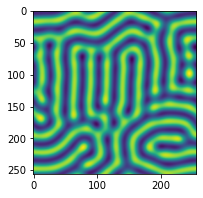

In [1]:
import scipy.io as sio
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/ml_experiments')
from myPDEFIND import *
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/numerics')
import convection_patterns as cp

# cp.solveSH(20*np.pi,20*np.pi,256,256,.1,100,"SHAutoEncode_2",Rscale=.5,
#            beta=.45,amplitude=.1,init_flag=1,energy=False)

data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/SHAutoEncode_2.mat")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.imshow(data['uu'][:,:,500].T)

Load data, and make sure it looks ok

In [2]:
tt = data['tt'][0][1:] #TVALUES, EXCLUDING FIRST ONE
xx = data['xx']
yy = data['yy']
U = data['uu'][:,:,1:] #TAKE LAST 1000 U surfaces
dt = data['tt'][0][1]-data['tt'][0][0]
Ut = BackwardDiff(U,data['uu'][:,:,0:1000],dt) #Compute U derivatives
n_samples = len(tt)
N = len(xx)*len(yy)
perm = np.random.permutation(int(.9*n_samples))
training_samples = perm[:int(.8*n_samples)]
val_samples = perm[int(.8*n_samples):]
test_samples = np.arange(int(.9*n_samples), n_samples)

training_data = {'tt': tt[training_samples],
                     'xx': xx.T,
                     'yy': yy.T,
                     'U': U[:,:,training_samples],
                     'Ut': Ut[:,:,training_samples]}
val_data = {'tt': tt[val_samples],
                'xx': xx.T,
                'yy': yy.T,
                'U': U[:,:,val_samples],
                'Ut': Ut[:,:,val_samples]}
test_data = {'tt': tt[test_samples],
                 'xx': xx.T,
                 'yy': yy.T,
                 'U': U[:,:,test_samples],
                 'Ut': Ut[:,:,test_samples]}


Split data into train and test

In [3]:
import tensorflow as tf

print(np.shape(training_data['U']))

input_data = tf.keras.layers.Input(shape=(len(xx), len(yy),1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(input_data)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = tf.keras.layers.Dense(1,activation='linear')(x)
encoder = tf.keras.models.Model(input_data, encoded)
encoder.summary()

decoder_input= tf.keras.layers.Input(shape=(int(len(xx)/8), int(len(yy)/8),1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(decoder_input)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Dense(1,activation='linear')(x)
decoder = tf.keras.models.Model(decoder_input, decoded)
decoder.summary()

auto_input = tf.keras.layers.Input(shape=(len(xx),len(yy),1))
encoded = encoder(auto_input)
decoded = decoder(encoded)
auto_encoder = tf.keras.models.Model(auto_input, decoded)
auto_encoder.summary()

auto_encoder.compile(loss='mean_squared_error', optimizer= tf.keras.optimizers.Adam(learning_rate=0.01))

auto_encoder.fit(training_data['U'].T, training_data['U'].T,
                epochs=10,
                batch_size=10,
                shuffle=True,
                validation_data=(test_data['U'].T, test_data['U'].T)
               )

(256, 256, 800)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3

2022-11-23 22:10:10.419907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 1)       289 

Auto encoder for data on square grid

In [4]:
uhat500 = auto_encoder.predict(data['uu'][:,:,500].T)

ValueError: in user code:

    File "/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "model" (type Functional).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (32, 256)
    
    Call arguments received by layer "model" (type Functional):
      • inputs=tf.Tensor(shape=(32, 256), dtype=float32)
      • training=False
      • mask=None
